## Stress Prediction Among Nurses: Insights and Challenges from a Random Forest Model 👩‍⚕️

It seeks to predict nurses' stress (Dependent Variable) during a pandemic based on metrics monitored with E4 watchbrust, such as heart rate, electrodermal activity and skin temperature (Independent Variable). For this process, there is one dataset with all the information contain ([".csv"](https://github.com/guadag12/ce888-assigment))

Stress is measured from an ordinal scale where 0 indicates 'no stress', 1 is 'there are signs of stress', 2 is 'high stress'. Likewise, and in this case, the responses to the level of stress that contain 'na' have been eliminated since they were not situations recognized as stressful by the nurses.

It is important to mention that the data was merge using a 5 seconds windows for every nurse. So, they are agruped every 5 seconds.

This code is divided into five parts:

1. [Packages & data](#section1)
2. [Import datasets](#section2)
3. [Exploration & Visualization](#section3)
4. [Modelling](#section4)
5. [Some conclusions & limitations of the data](#section5)
6. [References](#section6)

## 1. Packages & Data 📦 <a class="anchor" id="section1"></a>

In [1]:
! pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.1 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import warnings
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from datetime import timedelta
from sklearn.model_selection  import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patches as mpatches
import ruptures as rpt
from math import pi
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

## 2. Import datasets 💻<a class="anchor" id="section2"></a>

In [4]:
txt = '''Hosseini, Seyedmajid et al. (2021)'''

In [49]:
data=pd.read_csv("https://github.com/guadag12/ce888-assigment/raw/main/data_model.csv")
data =data.drop('Unnamed: 0', axis =1)

In [6]:
print(f'El dataset cuenta con {len(data)} observaciones')

El dataset cuenta con 62194 observaciones


In [13]:
data.tail(2)

,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,id,label,EDA_mean,EDA_min,EDA_max,EDA_std,HR_mean,HR_min,HR_max,HR_std,TEMP_mean,TEMP_min,TEMP_max,TEMP_std,HR_rms,TEMP_rms,num_Peaks,amphitude,duration,EDA_skew,EDA_kurtosis
62192,72.364,71.142,70.602,70.592,70.682,70.818,70.480,70.606,70.626,71.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.457077,5.266723,5.517879,5.680171,5.466154,5.094887,5.378590,5.253333,4.827884,4.610923,83,2.0,4.285708,3.908063,4.807611,0.307032,72.75,72.17,73.30,0.400402,NaN,NaN,NaN,NaN,0.044967,NaN,3.0,0.129423,31.126322,0.656207,-1.158647
62193,71.142,70.602,70.592,70.682,70.818,70.480,70.606,70.626,71.334,72.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.266723,5.517879,5.680171,5.466154,5.094887,5.378590,5.253333,4.827884,4.610923,4.285708,83,2.0,4.775576,4.775576,4.775576,NaN,73.55,73.55,73.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN


##  3. Exploration & Visualization 📊   <a class="anchor" id="section3"></a>

In order to do the exploration it is important to take into account that the level of stress for every nurses would be different. Plot no.1. try to show this, because it will affect severely the evaluation metrics.

As we can see in the Plot no.1. there are nurses that lives most of their time under several stress ('15', '6B', '7A', '7E', '83', '8B', 'CE', 'DF', 'E4', 'EG', 'F5'). '6D' of them lives under no stress most of the time, and '5C' it has moments of severe stress, moments of calmer stress and moments of no stress.

Saying this, it is important to mention that from the 15 cases of nurses, we are going to take 3 to show different examples of how the model behaves for each one. We will see how the model behaves in cases where:
* The **3 levels of stress** are witnessed **in similar proportions** ("5C" case)
* There are higher levels of **severe stress** ("15" case)
* There are practically **no stress situations** ("6D" case)

<Figure size 900x700 with 0 Axes>

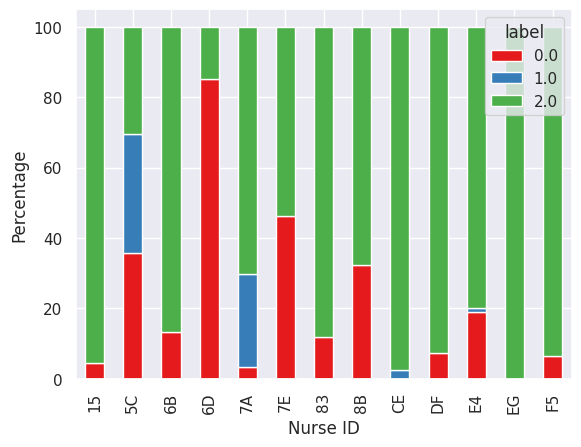

In [7]:
from matplotlib.colors import ListedColormap

flatui = ["#e41a1c", "#377eb8", "#4daf4a"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

data_group = data.groupby(["id", "label"], as_index = False)["label"].value_counts()
data_group['percent'] = data_group.groupby('id')['count'].apply(lambda x: 100 * x / float(x.sum()))

data_pivot = data_group.pivot(index='id', columns='label', values='percent')

sns.set(style="darkgrid")
plt.figure(figsize=(9,7))
data_pivot.plot(kind='bar', stacked=True, cmap=my_cmap)
plt.xlabel('Nurse ID')
plt.ylabel('Percentage')
#plt.title('Plot no.1: Stacked Bar Plot')
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot1.png', dpi=100)
plt.show();

In the paper of Hosseini, Seyedmajid et al. (2021) they mention how **EDA is highly correlated with stress**. The average electrodermal activity is higher in stressful contexts. However, it is hard to verify in Plot no.2.

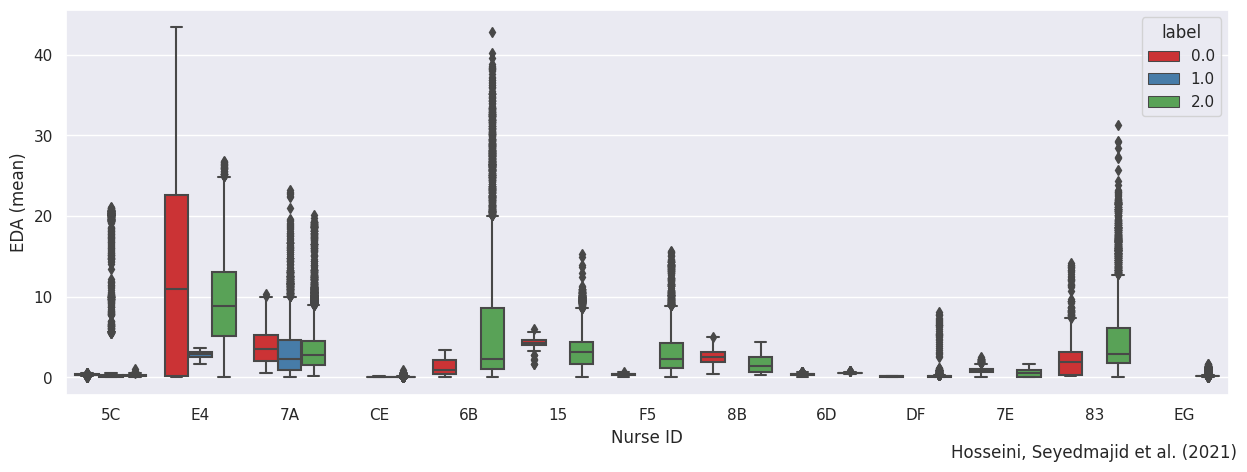

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
ax = plt.axes()
#ax.set_title('Plot no.2.: Relationship between the mean of electrodermal activity (EDA) & stress')
sns.boxplot(y="EDA_mean", x="id", hue="label", data=data, palette="Set1")
ax.set(xlabel='Nurse ID', ylabel='EDA (mean)')
ax.text(9.4,-10,txt)
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot2.png', dpi=100)
plt.show()

**High heart rate levels** can be associated with stressful situations and physical activity. So, it is easier to determine and include it in a model with the acceleration data that determine if the person is doing or not physical activity. However, this is something that the paper did not do it.

As we can see in plot no.3 does not appear to change the distribution of the no stress and the low or high stress. The high-stress situation may be more up and its seems that the data is more disperse and has more variability in high stress situations.

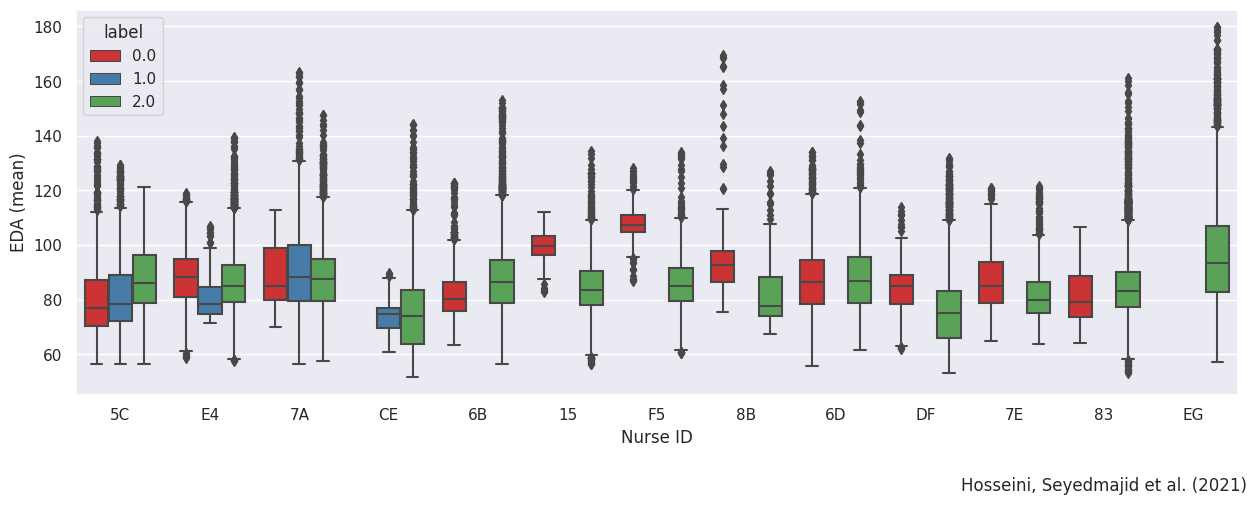

In [9]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
ax = plt.axes()
#ax.set_title('Plot no.3.: Relationship between the mean of heart rate & stress')
sns.boxplot(y="HR_mean", x="id", hue="label", data=data, palette="Set1")
ax.set(xlabel='Nurse ID', ylabel='EDA (mean)')
ax.text(9.4,10,txt)
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot3.png', dpi=100)
plt.show()

Now we are going to do a series of plots (4, 5, 6) with our 3 main cases: 
* **"5C"** (balanced stress levels)
* **"15"** (severe stress levels situations)
* **"6D"** (almost no stress situations)

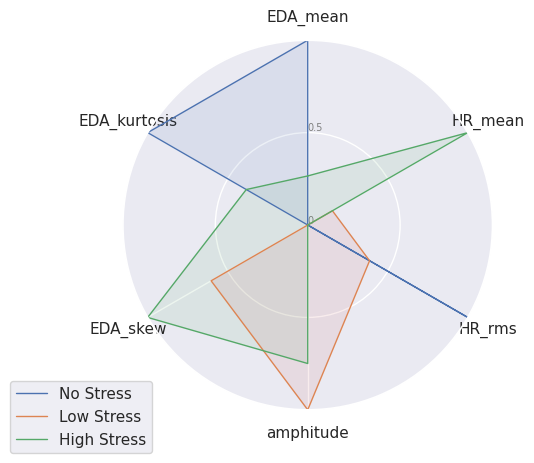

In [10]:
from math import pi
data_5C= data[data["id"] == "5C"]
df = data_5C.groupby(["label", "id"], as_index = False).median()

normalize_df=(df.iloc[:,2:]-df.iloc[:,2:].min())/(df.iloc[:,2:].max()-df.iloc[:,2:].min())
normalize_df = pd.concat([normalize_df, df.iloc[:,0]], axis = 1)
normalize_df = normalize_df[["EDA_mean", "HR_mean",# "num_Peaks", 
                             "HR_rms", "amphitude", "EDA_skew", "EDA_kurtosis", "label"]].groupby("label", as_index=False).median()
normalize_df.loc[0, "label"] = "No Stress"
normalize_df.loc[1, "label"] = "Low Stress"
normalize_df.loc[2, "label"] = "High Stress"

categories = list(normalize_df)[1:]

N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar = True)
ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks([0,0.5,1.3], ["0", "0.5", "1.3"], color = "grey", size = 7)
plt.ylim(0,1)

#["#35193e", "#701f57", "#ad1759", "#e13342", "#f37651", "#f6b48f"]
values = normalize_df.loc[0].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "No Stress")
ax.fill(angles, values, 'b', alpha = 0.1)

values = normalize_df.loc[1].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "Low Stress")
ax.fill(angles, values, 'r', alpha = 0.1)

values = normalize_df.loc[2].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "High Stress")
ax.fill(angles, values, 'g', alpha = 0.1)
plt.legend(loc = "upper right", bbox_to_anchor =(0.1,0.1))
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot4.png', dpi=100)
plt.show()

In plot no.4. we can see for the nurse '5C' (balanced level of stress and no stress situations) how the different variables interact with each others and its seems like high levels of stress are associated with a combination of high rate mean  and skew electrodelmal activity.

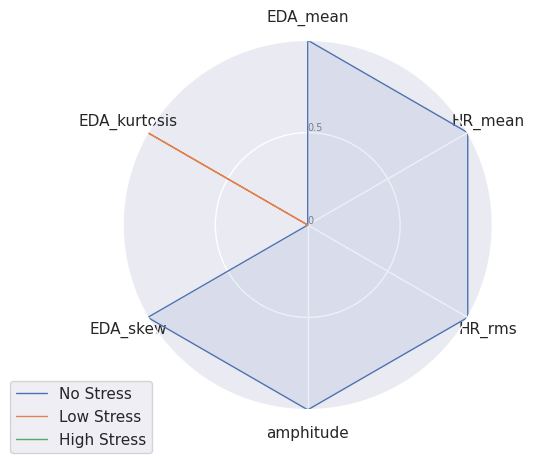

In [11]:
from math import pi
data_15= data[data["id"] == "15"]
df = data_15.groupby(["label", "id"], as_index = False).median()

normalize_df=(df.iloc[:,2:]-df.iloc[:,2:].min())/(df.iloc[:,2:].max()-df.iloc[:,2:].min())
normalize_df = pd.concat([normalize_df, df.iloc[:,0]], axis = 1)
normalize_df = normalize_df[["EDA_mean", "HR_mean", #"num_Peaks", 
                             "HR_rms", "amphitude", "EDA_skew", "EDA_kurtosis", "label"]].groupby("label", as_index=False).median()


normalize_df.loc[0.0, "label"] = "No Stress"
normalize_df.loc[1.0, "label"] = "Low Stress"
normalize_df.loc[2.0, "label"] = "High Stress"

categories = list(normalize_df)[1:]

N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar = True)
ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks([0,0.5,1.3], ["0", "0.5", "1.3"], color = "grey", size = 7)
plt.ylim(0,1)

values = normalize_df.loc[0].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "No Stress")
ax.fill(angles, values, 'b', alpha = 0.1)

values = normalize_df.loc[1].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "Low Stress")
ax.fill(angles, values, 'r', alpha = 0.1)

values = normalize_df.loc[2].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "High Stress")
ax.fill(angles, values, 'g', alpha = 0.1)
#ax.set_title('Plot no.5.: Radar variables related with stress (15 nurse)')
plt.legend(loc = "upper right", bbox_to_anchor =(0.1,0.1))
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot5.png', dpi=100)
plt.show()

Without any coincidence with the previous case (plot no.4.) the "15" nurse (that suffer severe levels of stress most of the time) does not show any pattern significant to predict stress

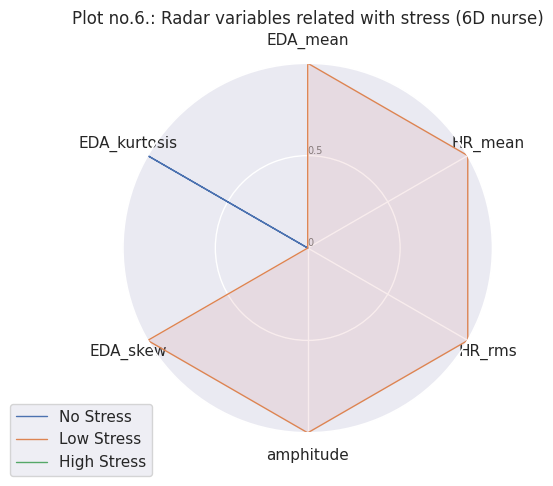

In [12]:
data_6D= data[data["id"] == "6D"]
df = data_6D.groupby(["label", "id"], as_index = False).median()

normalize_df=(df.iloc[:,2:]-df.iloc[:,2:].min())/(df.iloc[:,2:].max()-df.iloc[:,2:].min())
normalize_df = pd.concat([normalize_df, df.iloc[:,0]], axis = 1)
normalize_df = normalize_df[["EDA_mean", "HR_mean", #"num_Peaks",
                             "HR_rms", 
                             "amphitude", "EDA_skew", "EDA_kurtosis", "label"]].groupby("label", as_index=False).median()


normalize_df.loc[0, "label"] = "No Stress"
normalize_df.loc[1, "label"] = "Low Stress"
normalize_df.loc[2, "label"] = "High Stress"

categories = list(normalize_df)[1:]

N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar = True)
ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks([0,0.5,1.3], ["0", "0.5", "1.3"], color = "grey", size = 7)
plt.ylim(0,1)

values = normalize_df.loc[0].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "No Stress")
ax.fill(angles, values, 'b', alpha = 0.1)

values = normalize_df.loc[1].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "Low Stress")
ax.fill(angles, values, 'r', alpha = 0.1)

values = normalize_df.loc[2].drop("label").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle = "solid", label = "High Stress")
ax.fill(angles, values, 'g', alpha = 0.1)
ax.set_title('Plot no.6.: Radar variables related with stress (6D nurse)')

plt.legend(loc = "upper right", bbox_to_anchor =(0.1,0.1))
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot6.png', dpi=100)
plt.show()

In **plot no. 6**, contrary to plot no.5 but similar to plot 4., stress might be related with a combination between EDA skew and other variables like heart rate and number of peaks. 

In **plot no.7.** we can see the progress of the main 3 metrics: "EDA_mean", "HR_mean" and "TEMP_mean":

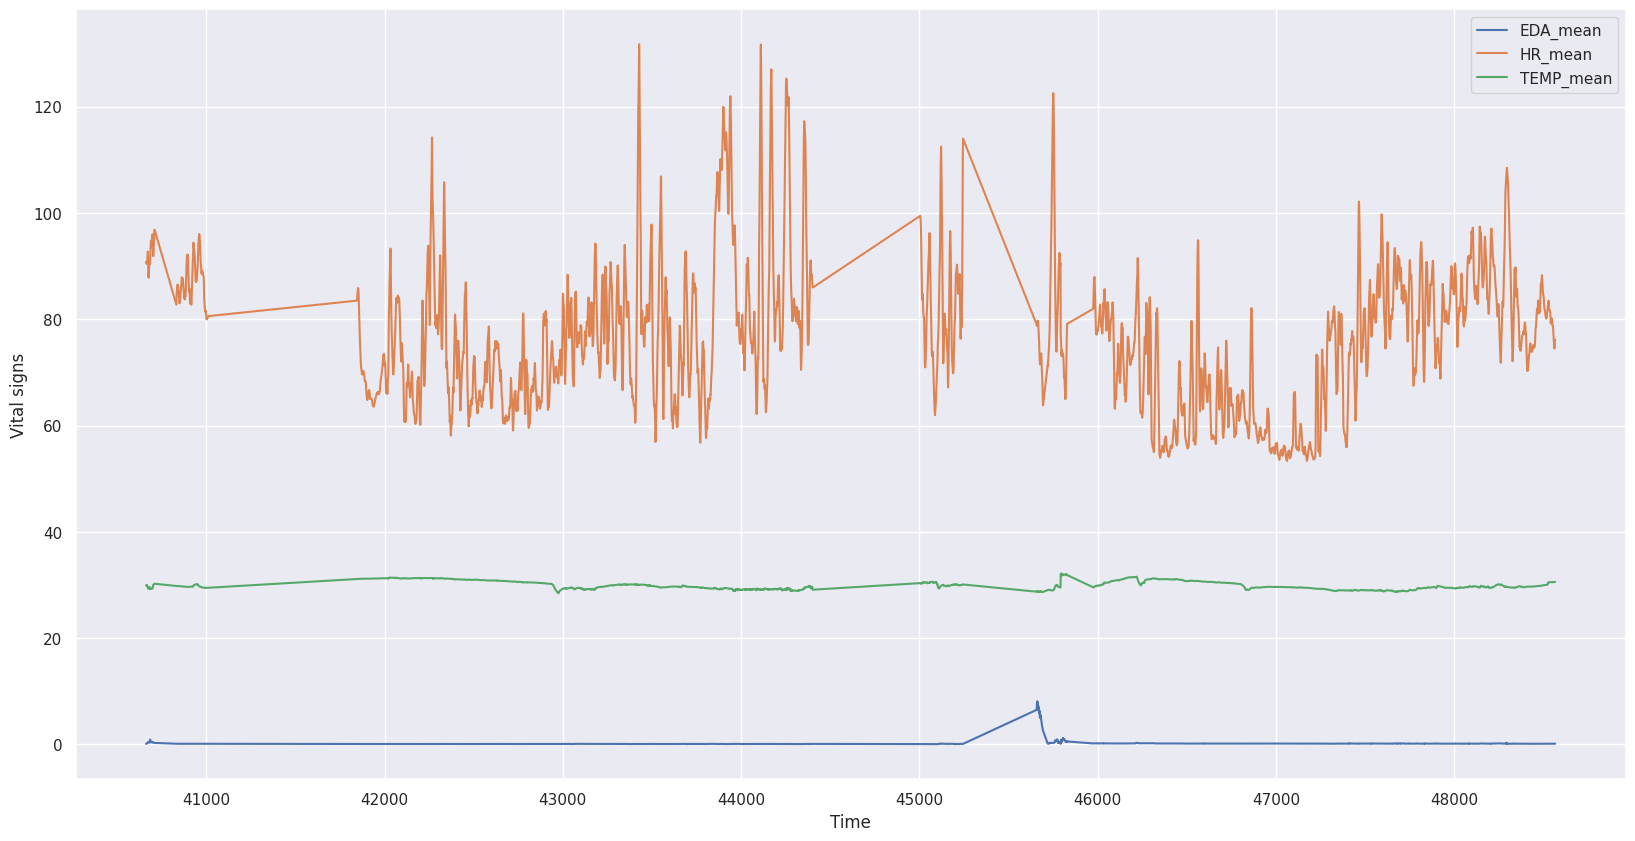

In [13]:
sns.set(style="darkgrid")
data.loc[data['id'] == "DF", ["EDA_mean", "HR_mean", "TEMP_mean"]].plot(subplots=False, figsize=(20, 10)); plt.legend(loc='best')
plt.xlabel('Time') 
plt.ylabel('Vital signs') 
#plt.title("Plot no.7.: Evolution of the differents vital signs of Nurse 'DF'")
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot7.png', dpi=100)

Another interesting thing to see is how the stress situations are changing in time, so the model has to adapt to this variations that can be change from one nurse to another. That is whay plot no.8 and 9 are showing. 




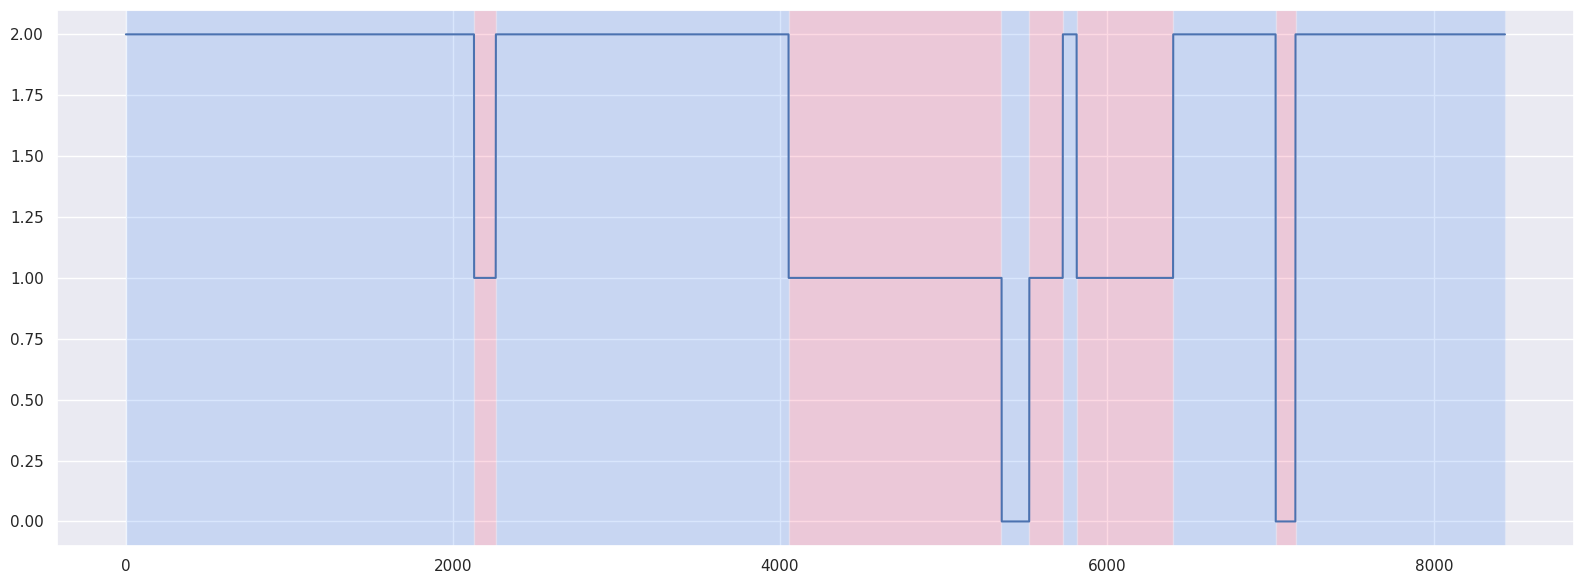

In [14]:
data_user = data[data["id"] == "7A"]
signal = data_user["label"].values
algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)
rpt.display(signal, result, figsize=(16, 6))
#plt.title('Plot no.8: Pelt Search Change Detection Method for nurse "7A"')
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot8.png', dpi=100)
plt.show()

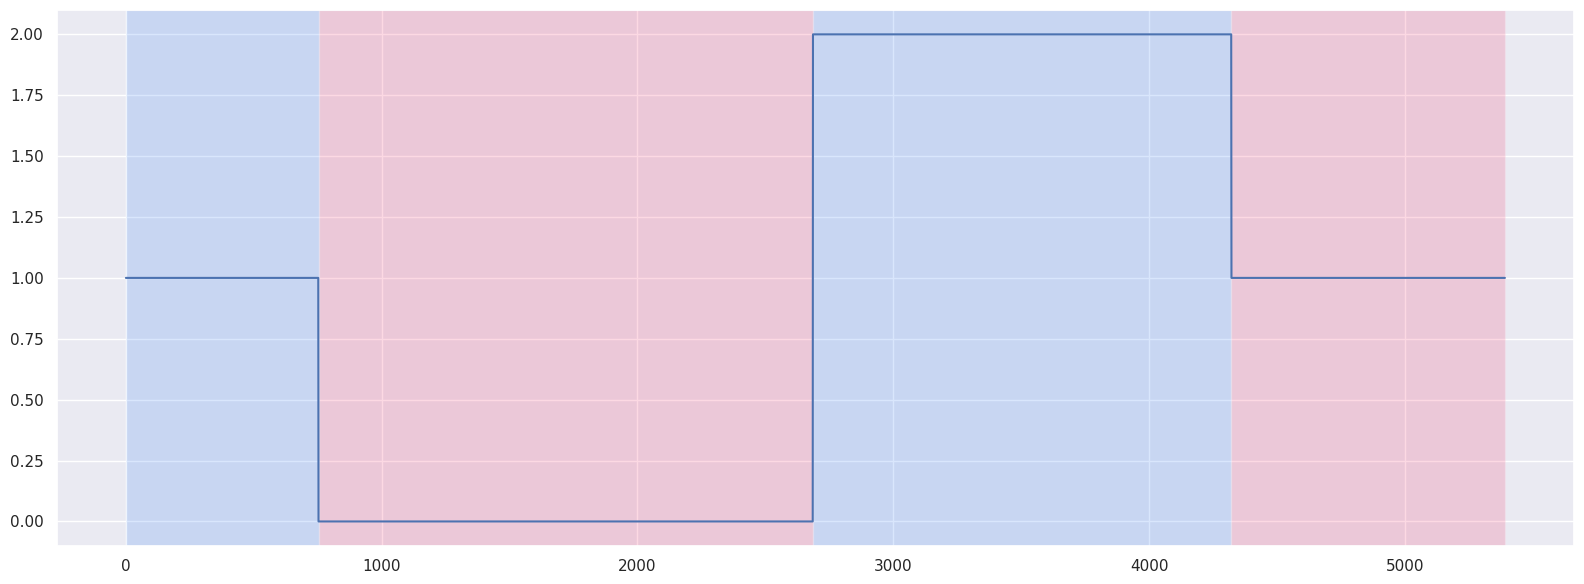

In [15]:
data_user = data[data["id"] == "5C"]
signal = data_user["label"].values
algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)
rpt.display(signal, result, figsize=(16, 6))
#plt.title('Plot no.9: Pelt Search Change Detection Method for nurse "5C"')
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot9.png', dpi=100)
plt.show()

## 4. Modelling 📈  <a class="anchor" id="section4"></a>

In this code you can see **two models**:
1. A Random Forest model for all nurses
2. A random forest model for each participant whose evaluation metrics can be seen in table no.1 and plot no.8.
3. A model that tries to predict the stress of the person in the next 5 and 10 seconds.

## Part I: Generalized Random Forest 🌳  <a class="anchor" id="section3a"></a> 


In [22]:
data=pd.read_csv("https://github.com/guadag12/ce888-assigment/raw/main/data_model.csv")
data =data.drop('Unnamed: 0', axis =1)

data_all =data
data_all["label"] = np.where(data_all["label"] == 0, 0, 1)
data_all=data_all[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis', "label"]]
#le = LabelEncoder()
#data_all['id'] = le.fit_transform(data_all['id'])
data_all=data_all.dropna()
float_cols = data_all.select_dtypes(include=['float64']).columns
data_all[float_cols] = data_all[float_cols].astype('float32')

k_folds = 5

# random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the scaler
scaler = StandardScaler()

# Create the cross-validation object
k_fold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Loop over the folds
val_accs = []
val_f1 = []
val_precision = []
val_recall = []
for train_idx, val_idx in k_fold.split(data_all):
    # Split the data into train and validation sets
    X_train, y_train = data_all.iloc[train_idx,:-1], data_all.iloc[train_idx,-1]
    X_val, y_val = data_all.iloc[val_idx,:-1], data_all.iloc[val_idx,-1]
    
    # Scale the features
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Fit the model on the train set and predict on the validation set
    rf_model.fit(X_train, y_train)
    val_pred = rf_model.predict(X_val)
    
    # Calculate accuracy on the validation set
    val_acc = accuracy_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred)
    recall = recall_score(y_val, val_pred)

    val_accs.append(val_acc)
    val_f1.append(f1)
    val_precision.append(precision)
    val_recall.append(recall)


# Calculate the average validation metrics over all folds
avg_val_acc = sum(val_accs) / len(val_accs)
avg_val_f1 = sum(val_f1) / len(val_f1)
avg_val_prec = sum(val_precision) / len(val_precision)
avg_val_recall = sum(val_recall) / len(val_recall)

metrics = {'accuracy': [avg_val_acc], 'f1': [avg_val_f1], 'precision': [avg_val_prec], 'recall': [avg_val_recall]}
new_metrics = pd.DataFrame(data=metrics)

In [23]:
print("Table no.1.:"), 
new_metrics

Table no.1.:


,accuracy,f1,precision,recall
0,0.924372,0.95555,0.93321,0.978993


In [24]:
#save the metrics in latex to upload to overleaf later:
new_metrics.round(2).sort_values(by=['accuracy']).to_latex('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/table01.tex',
                                  index=False,  caption="General Random Forest Model's evaluation metrics")

In [25]:
#prepare the data to plot the ROC curve with a no cross validation example:
clf1 = RandomForestClassifier(n_estimators=100,max_depth=15)
X = data_all.drop(["label"], axis = 1)
y = data_all["label"]
train1, test1, train_labels1, test_labels1 = train_test_split(X, y, test_size=0.33, random_state=30, shuffle = True)
scaler = StandardScaler()
scaler.fit(train1)
train1 = scaler.transform(train1)
scaler.fit(test1)
test1= scaler.transform(test1)
clf1.fit(train1, train_labels1.values.ravel())
logit_roc_auc1 = roc_auc_score(test_labels1, clf1.predict(test1))
fpr1, tpr1, thresholds1 = roc_curve(test_labels1, clf1.predict_proba(test1)[:,1])

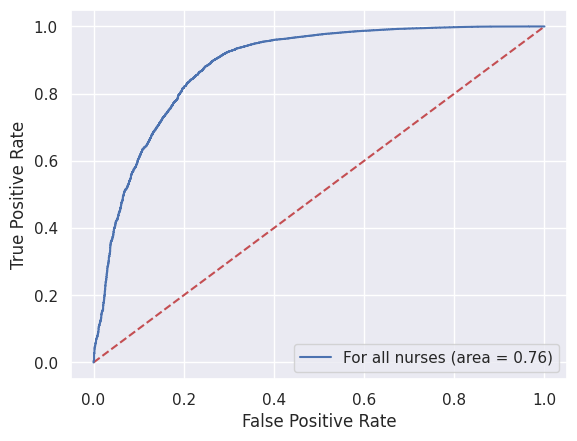

In [26]:
sns.set(style="darkgrid")
plt.figure(0).clf()
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr1,tpr1,label="For all nurses (area = %0.2f)" % logit_roc_auc1)
#plt.title("Plot no. 10.: Receiver operating characteristic for Random Forest")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.legend(loc=0)
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot10.png', dpi=100)

## Part II: Random Forest for each nurse 🌳  <a class="anchor" id="section3a"></a> 


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [28]:
#bring the dataset:
data=pd.read_csv("https://github.com/guadag12/ce888-assigment/raw/main/data_model.csv")
data =data.drop('Unnamed: 0', axis =1)

In [29]:
#In data_measures object we are going to keep the metrics that we want to analyze later for each nurse
d = {'id':[], 'accuracy': [], 'f1': [], 'precision':[], 'recall':[]}
data_measures = pd.DataFrame(data=d)
data_measures["id"][0] = 1
data_measures

,id,accuracy,f1,precision,recall


In [32]:
d = {'id':[], 'accuracy': [], 'f1': [], 'precision':[], 'recall':[]}
data_measures = pd.DataFrame(data=d)
j = 0
for i in np.unique(data.id):
  data_user =data[data["id"] == i]
  data_user["label"] = np.where(data_user["label"] == 0, 0, 1)
  data_user=data_user[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
            '6', '5', '4', '3', '2', '1', 'EDA_mean', 'EDA_min',
            'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
            'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis', 'label']]
  data_user=data_user.dropna()
  data_user1 = data_user.iloc[:-1,]
  #data_user1 = data_user1.drop(["id"], axis = 1)
  float_cols = data_user1.select_dtypes(include=['float64']).columns
  data_user1[float_cols] = data_user1[float_cols].astype('float32')

  #Create a random forest classifier
  clf = RandomForestClassifier(n_estimators=100,max_depth=15)

  # Create the cross-validation object
  k_fold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

  # Loop over the folds
  val_accs = []
  val_f1 = []
  val_precision = []
  val_recall = []
  for train_idx, val_idx in k_fold.split(data_user1):
      # Split the data into train and validation sets
      X_train, y_train = data_user1.iloc[train_idx,:-1], data_user1.iloc[train_idx,-1]
      X_val, y_val = data_user1.iloc[val_idx,:-1], data_user1.iloc[val_idx,-1]
      
      # Scale the features
      X_train = scaler.fit_transform(X_train)
      X_val = scaler.transform(X_val)

      # Fit the model on the train set and predict on the validation set
      rf_model.fit(X_train, y_train)
      val_pred = rf_model.predict(X_val)
      
      # Calculate accuracy on the validation set
      val_acc = accuracy_score(y_val, val_pred)
      f1 = f1_score(y_val, val_pred)
      precision = precision_score(y_val, val_pred)
      recall = recall_score(y_val, val_pred)

      val_accs.append(val_acc)
      val_f1.append(f1)
      val_precision.append(precision)
      val_recall.append(recall)

  # Calculate the average validation metrics over all folds
  avg_val_acc = sum(val_accs) / len(val_accs)
  avg_val_f1 = sum(val_f1) / len(val_f1)
  avg_val_prec = sum(val_precision) / len(val_precision)
  avg_val_recall = sum(val_recall) / len(val_recall)

  new_data = {'id': [i], 'accuracy': [avg_val_acc], 'f1': [avg_val_f1], 'precision': [avg_val_prec], 'recall': [avg_val_recall]}
    
  # create a new DataFrame from the new data
  new_df = pd.DataFrame(data=new_data)

   # append the new DataFrame to the original DataFrame
  data_measures = data_measures.append(new_df, ignore_index=True)

  j = j+1

In [33]:
### see metrics of the model:
data_group["label_cat"] = np.where(data_group["label"] == 0, "No_stress (%)", "Low_or_high_stress (%)")
data_group_merge = data_group.pivot_table(values='percent', index='id', columns='label_cat', aggfunc=sum, fill_value=0).reset_index()
data_measures_m=data_measures.merge(data_group_merge, on = "id").sort_values(by=['accuracy'])
data_measures_m["difference"] = data_measures_m["No_stress (%)"] - data_measures_m["Low_or_high_stress (%)"]
print("Table no.1.: Model evaluation metrics"); data_measures_m.round(2).sort_values(by=['accuracy', "difference"])

Table no.1.: Model evaluation metrics


,id,accuracy,f1,precision,recall,Low_or_high_stress (%),No_stress (%),difference
5,7E,0.91,0.91,0.93,0.89,53.74,46.26,-7.48
1,5C,0.93,0.95,0.96,0.93,64.15,35.85,-28.30
6,83,0.94,0.97,0.94,0.99,88.09,11.91,-76.18
3,6D,0.95,0.82,0.87,0.79,14.98,85.02,70.05
2,6B,0.96,0.98,0.96,1.00,86.85,13.15,-73.69
4,7A,0.97,0.99,0.97,1.00,96.56,3.44,-93.12
10,E4,0.97,0.98,0.97,1.00,81.05,18.95,-62.10
0,15,0.99,0.99,0.99,1.00,95.63,4.37,-91.25
9,DF,0.99,0.99,0.99,1.00,92.79,7.21,-85.57
7,8B,0.99,0.99,0.99,0.99,67.71,32.29,-35.42


If we pay attention to **table no.1.** we can see that the accuracy is higher when the difference between the percentage of "stress" and "no stress" is higher. So, more imbalanced are the classes, more accuracy. Which makes sense because if you have almost 90% of the cases positive for stress, the algorithm have less chances to confused about it.

In this context it is important cases like **"7E"** because has the classes really balance, and even though the accuracy it is 0.91.

In [35]:
#####################################################################################
#### This is the code needed to be run before the plot of the ROC curve  ############

### Nurse "5C"
data_user =data[data["id"] == "5C"]
data_user["label"] = np.where(data_user["label"] == 0, 0, 1)
data_user=data_user[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'id', 'label', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']]
data_user=data_user.dropna()
data_user1 = data_user.iloc[:-1,]
X = data_user1.drop(["label", "id"], axis = 1)
y = data_user1["label"]
float_cols = X.select_dtypes(include=['float64']).columns
X[float_cols] = X[float_cols].astype('float32')
y = y.astype('float32')
clf1 = RandomForestClassifier(n_estimators=100,max_depth=15)
train1, test1, train_labels1, test_labels1 = train_test_split(X, y, test_size=0.33, random_state=30, shuffle = True)
scaler = StandardScaler()
scaler.fit(train1)
train1 = scaler.transform(train1)
scaler = StandardScaler()
scaler.fit(test1)
test1= scaler.transform(test1)
clf1.fit(train1, train_labels1.values.ravel())
logit_roc_auc1 = roc_auc_score(test_labels1, clf1.predict(test1))
fpr1, tpr1, thresholds1 = roc_curve(test_labels1, clf1.predict_proba(test1)[:,1])

### Nurse "15"
data_user =data[data["id"] == "15"]
data_user["label"] = np.where(data_user["label"] == 0, 0, 1)
data_user=data_user[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'id', 'label', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']]
data_user=data_user.dropna()
data_user1 = data_user.iloc[:-1,]
X = data_user1.drop(["label", "id"], axis = 1)
y = data_user1["label"]
float_cols = X.select_dtypes(include=['float64']).columns
X[float_cols] = X[float_cols].astype('float32')
y = y.astype('float32')
clf2 = RandomForestClassifier(n_estimators=100,max_depth=15)
train2, test2, train_labels2, test_labels2 = train_test_split(X, y, test_size=0.33, random_state=30, shuffle = True)
scaler = StandardScaler()
scaler.fit(train2)
train2 = scaler.transform(train2)
scaler.fit(test2)
test2= scaler.transform(test2)
clf2.fit(train2, train_labels2.values.ravel())
logit_roc_auc2 = roc_auc_score(test_labels2, clf2.predict(test2))
fpr2, tpr2, thresholds2 = roc_curve(test_labels2, clf2.predict_proba(test2)[:,1])

### Nurse "6D"
data_user_6D = data[data["id"] == "6D"]
data_user["label"] = np.where(data_user["label"] == 0, 0, 1)
data_user=data_user[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'id', 'label', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']]
data_user=data_user.dropna()
data_user1 = data_user.iloc[:-1,]
X = data_user1.drop(["label", "id"], axis = 1)
y = data_user1["label"]
float_cols = X.select_dtypes(include=['float64']).columns
X[float_cols] = X[float_cols].astype('float32')
y = y.astype('float32')
clf3 = RandomForestClassifier(n_estimators=100,max_depth=15)
train3, test3, train_labels3, test_labels3 = train_test_split(X, y, test_size=0.33, random_state=30, shuffle = True)
scaler = StandardScaler()
scaler.fit(train3)
train3 = scaler.transform(train3)
scaler.fit(test3)
test3= scaler.transform(test3)
clf3.fit(train3, train_labels3.values.ravel())
logit_roc_auc3 = roc_auc_score(test_labels3, clf3.predict(test3))
fpr3, tpr3, thresholds3 = roc_curve(test_labels3, clf3.predict_proba(test3)[:,1])

In [36]:
print("Te predicted values for the mean values in nurse '5C' (that has balanced stress situation is):", clf1.predict( 
    data[data["id"] == "5C"][['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']].describe().loc[['mean']]
    )[0])

Te predicted values for the mean values in nurse '5C' (that has balanced stress situation is): 1.0


In [37]:
print("Te predicted values for the mean values in nurse '15' (that has most stress situation is):", clf2.predict( 
    data[data["id"] == "15"][['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']].describe().loc[['mean']]
    )[0])

Te predicted values for the mean values in nurse '15' (that has most stress situation is): 1.0


In [38]:
print("Te predicted values for the mean values in nurse '6D' (that has almost no stress situation is):", clf3.predict( 
    data[data["id"] == "6D"][['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
          '6', '5', '4', '3', '2', '1', 'EDA_mean', 'EDA_min',
          'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
          'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']].describe().loc[['mean']]
    )[0])

Te predicted values for the mean values in nurse '6D' (that has almost no stress situation is): 1.0


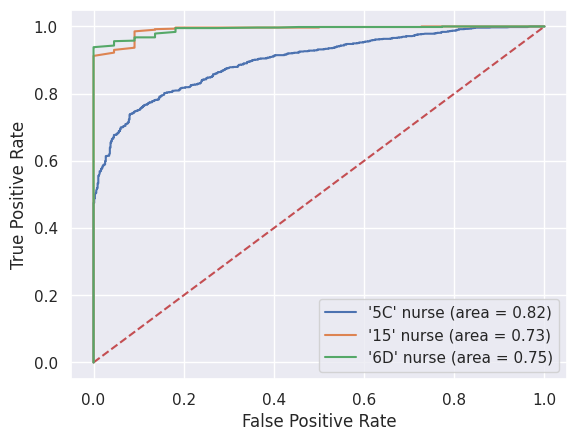

In [39]:
plt.figure(0).clf()
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr1,tpr1,label="'5C' nurse (area = %0.2f)" % logit_roc_auc1)
plt.plot(fpr2,tpr2,label="'15' nurse (area = %0.2f)" % logit_roc_auc2)
plt.plot(fpr3,tpr3,label="'6D' nurse (area = %0.2f)" % logit_roc_auc3)
#plt.title("Plot no. 10.: Receiver operating characteristic for Random Forest")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.legend(loc=0)
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot11.png', dpi=100)

As can be seen in **Plot no.10.** the model may discriminate better when you tend to have cases with higher percentage of no stress (negative cases), but the area under the curve in cases with a lot of severe stress (positive cases) has more flaws. When you have balanced data an intermediate value can be obtained (such as 0.85) which is not negligible.

In [40]:
#save the metrics in latex to upload to overleaf later:
data_measures_m.round(2).sort_values(by=['accuracy', "difference"]).to_latex('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/table02.tex',
                                  index=False,  caption="Model evaluation metrics")

## Part III: Stress prediction for the next 5 & 10 seconds 📉   <a class="anchor" id="section3b"></a>

For the second part of this code a model to try to predict in the next 5 or 10 seconds will be developed using the same Random Forest model.


### 5 seconds prediction

In this first try we are going to predict for the next 5 seconds for the user "5C" that has a balance between high stress, low stress and no stress situations.

In [41]:
# Load time series data into a pandas DataFrame
data_user =data[data["id"] == "5C"]
data_user["label"] = np.where(data_user["label"] == 0, 0, 1)
data_user=data_user[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
           '6', '5', '4', '3', '2', '1', 'id', 'label', 'EDA_mean', 'EDA_min',
           'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
           'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']]
data_user=data_user.dropna()
X = data_user.drop(["label", "id"], axis = 1)
y = data_user["label"]
float_cols = X.select_dtypes(include=['float64']).columns
X[float_cols] = X[float_cols].astype('float32')
y = y.astype('float32')

# Define the length of the sliding window in seconds
window_length = 5

# Define the number of rows to skip between each window
skip_rows = 1  

# Define the features you used in your original random forest model
features = X.columns

# Define the target variable you want to predict
target_variable = "label"

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30, shuffle = True)

y_train=y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)
# Train a random forest model on your training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Iterate over each window in your testing data
predictions = []
for i in range(0, len(data_user) - window_length, skip_rows):
    # Extract the data within the current window
    current_window = data_user.iloc[i:i+window_length]
    X_test = current_window[features]

    # Detect changes in the stress level using the Pelt algorithm in ruptures
    model = rpt.Pelt(model="rbf").fit(current_window[target_variable].to_numpy().reshape(-1, 1))
    change_points = model.predict(pen=1.0)

    # Make a prediction for the stress level within the current window
    predicted_stress_level = rf.predict(X_test)[0]
    predictions.append(predicted_stress_level)

y_true = data_user[target_variable][window_length-1:-1]
accuracy = accuracy_score(y_true, predictions)
print("Accuracy:", accuracy)

confusion_mat = confusion_matrix(y_true, predictions)
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.9748930630463084
Confusion Matrix:
 [[1863   69]
 [  66 3379]]


In [42]:
predict =data_user.iloc[-1:,]
predict=predict.drop(["label", "id"], axis = 1)
float_cols = predict.select_dtypes(include=['float64']).columns
predict[float_cols] = predict[float_cols].astype('float32')
scaler.fit(predict)
predict = scaler.transform(predict)

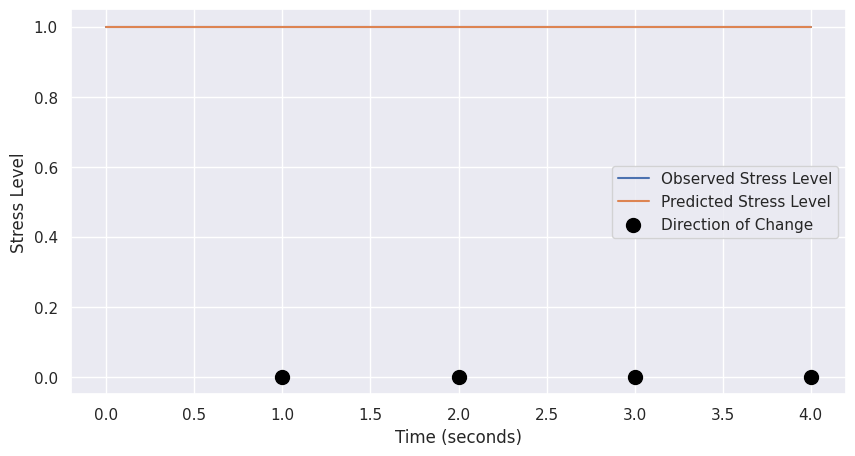

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
x_vals = np.arange(window_length)
y_observed = current_window[target_variable]
y_predicted = np.repeat(predicted_stress_level, window_length)
sign_markers = np.sign(y_observed.diff())
ax.plot(x_vals, y_observed, label="Observed Stress Level")
ax.plot(x_vals, y_predicted, label="Predicted Stress Level")
ax.scatter(x_vals[1:], y_observed.diff().values[1:], marker="o", s=100, c="black",
            label="Direction of Change")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Stress Level")
#ax.set_title("Plot no. 12: Predicted vs Observed Stress Level (5 seconds)")
ax.legend()
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot12.png', dpi=100)
plt.show()

In [44]:
print("Te predicted values is:", rf.predict(predict)[0], "& the actual value is", data_user['label'].iloc[-1])

Te predicted values is: 1.0 & the actual value is 1


### 10 seconds prediction


In [45]:
# Load time series data into a pandas DataFrame
data_user =data[data["id"] == "6D"]
data_user["label"] = np.where(data_user["label"] == 0, 0, 1)
data_user=data_user[['30', '29', '28', '27', '26', '25', '24', '23', '22', '21','10', '9', '8', '7',
           '6', '5', '4', '3', '2', '1', 'id', 'label', 'EDA_mean', 'EDA_min',
           'EDA_max', 'EDA_std', 'HR_mean', 'HR_min', 'HR_max', 'HR_std','HR_rms',
           'num_Peaks', 'amphitude', 'duration', 'EDA_skew', 'EDA_kurtosis']]
data_user=data_user.dropna()
X = data_user.drop(["label", "id"], axis = 1)
y = data_user["label"]
float_cols = X.select_dtypes(include=['float64']).columns
X[float_cols] = X[float_cols].astype('float32')
y = y.astype('float32')

# Define the length of the sliding window in seconds
window_length = 10

# Define the number of rows to skip between each window
skip_rows = 1  

# Define the features you used in your original random forest model
features = X.columns

# Define the target variable you want to predict
target_variable = "label"

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30, shuffle = True)

y_train=y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

# Train a random forest model on your training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Iterate over each window in your testing data
predictions = []
for i in range(0, len(data_user) - window_length, skip_rows):
    # Extract the data within the current window
    current_window = data_user.iloc[i:i+window_length]
    X_test = current_window[features]

    # Detect changes in the stress level using the Pelt algorithm in ruptures
    model = rpt.Pelt(model="rbf").fit(current_window[target_variable].to_numpy().reshape(-1, 1))
    change_points = model.predict(pen=1.0)

    # Make a prediction for the stress level within the current window
    predicted_stress_level = rf.predict(X_test)[0]
    predictions.append(predicted_stress_level)

y_true = data_user[target_variable][window_length-1:-1]
accuracy = accuracy_score(y_true, predictions)
print("Accuracy:", accuracy)

confusion_mat = confusion_matrix(y_true, predictions)
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.9831795984807379
Confusion Matrix:
 [[3114   29]
 [  33  510]]


In [46]:
predict =data_user.iloc[-1:,]
predict=predict.drop(["label", "id"], axis = 1)
float_cols = predict.select_dtypes(include=['float64']).columns
predict[float_cols] = predict[float_cols].astype('float32')
scaler.fit(predict)
predict = scaler.transform(predict)

In [47]:
print("Te predicted values is:", rf.predict(predict)[0], "& the actual value is", data_user['label'].iloc[-1])

Te predicted values is: 0.0 & the actual value is 0


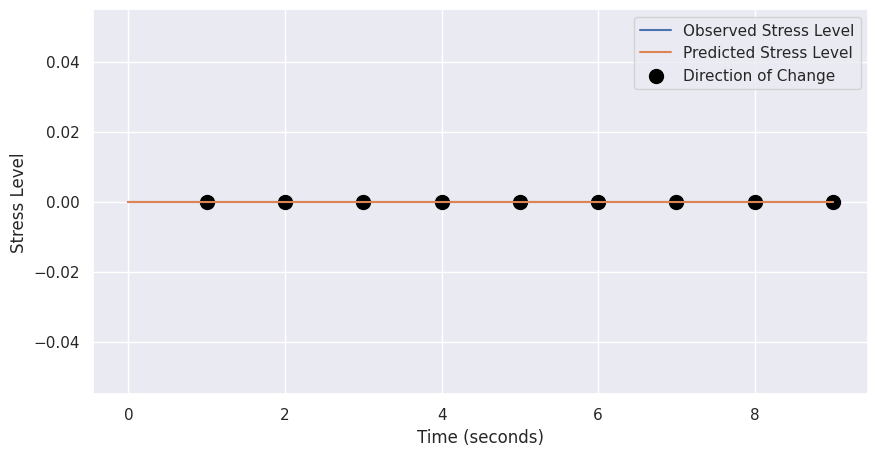

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
x_vals = np.arange(window_length)
y_observed = current_window[target_variable]
y_predicted = np.repeat(predicted_stress_level, window_length)
sign_markers = np.sign(y_observed.diff())
ax.plot(x_vals, y_observed, label="Observed Stress Level")
ax.plot(x_vals, y_predicted, label="Predicted Stress Level")
ax.scatter(x_vals[1:], y_observed.diff().values[1:], marker="o", s=100, c="black",
            label="Direction of Change")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Stress Level")
#ax.set_title("Plot no. 13: Predicted vs Observed Stress Level (10 seconds)")
ax.legend()
plt.savefig('/content/drive/MyDrive/CE888-7-SP - Data Science and Decision Making/Assigment/model/plot/plot13.png', dpi=100)
plt.show()

## 6. References 📚 <a class="anchor" id="section6"></a>

Hosseini, Seyedmajid et al. (2021), A multi-modal sensor dataset for continuous stress detection of nurses in a hospital, Dryad, Dataset, https://doi.org/10.5061/dryad.5hqbzkh6f

Siirtola, & Röning, J. (2020). Comparison of Regression and Classification Models for User-Independent and Personal Stress Detection. Sensors (Basel, Switzerland), 20(16), 4402–. https://doi.org/10.3390/s20164402